In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import numpyro
import numpy as np
from numpyro.infer import NUTS, MCMC
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

Here is the CMD for the points we are fitting, along with the TRGB inferred from [McQuinn, et al. (2017)](https://doi.org/10.3847/1538-3881/aa7aad).

In [McQuinn, et al. (2017)](https://iopscience.iop.org/article/10.3847/1538-3881/aa7aad), the metallicity correction is 
$$
A_\mathrm{F814W} = -4.06 + 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right).
$$

Putting this into our language, we have 
$$
A_\mathrm{F814W} - 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right) = -4.06 + \mu
$$
where $\mu$ is the distance modulus.  Thus we see that $c = -0.2$, and the centering parameter for $C = 1.23$, and then $e_\mathrm{centered} = -4.06 + \mu$.

[Rizzi, et al. (2007)](https://iopscience.iop.org/article/10.1086/516566) provides the TRGB slope used in McQuinn, et al. (2017) and gives an uncertainty of $0.01$, so we impose this with a prior.

In [59]:
data = pd.read_table('data/M63/M63_FOV_VIerr.dat', names=['V', 'Verr', 'I', 'Ierr'], delimiter=' ')

print('len(data) = {:d}'.format(len(data)))

trgb_mcquinn = 25.68
c_mcquinn = -0.2
c_center = 1.23

# A0_cut = 27.0 # See below

# BAD, BAD, BAD!
Vext = 0.043
Iext = 0.027
data['V'] = data['V'] - Vext
data['I'] = data['I'] - Iext

data['V-I'] = data['V'] - data['I']
data['IRectMcQ'] = data['I'] + c_mcquinn*(data['V-I'] - c_center)

data['Iflux'] = 10**(data['I']/-2.5)
data['Vflux'] = 10**(data['V']/-2.5)

data['Ifluxerr'] = data['Ierr'] * data['Iflux'] * np.log(100) / 5
data['Vfluxerr'] = data['Verr'] * data['Vflux'] * np.log(100) / 5

data_rgb = data
# rgb_mask = (data['V-I'] > 0.6) & (data['V-I'] < 2.5)
# data_rgb = data.loc[rgb_mask]

# data_cut = data.loc[data['I'] < A0_cut]

Nfit = 8192
inds = np.random.permutation(len(data_rgb))
data_cut = data_rgb.iloc[inds[:Nfit]]

len(data) = 38821


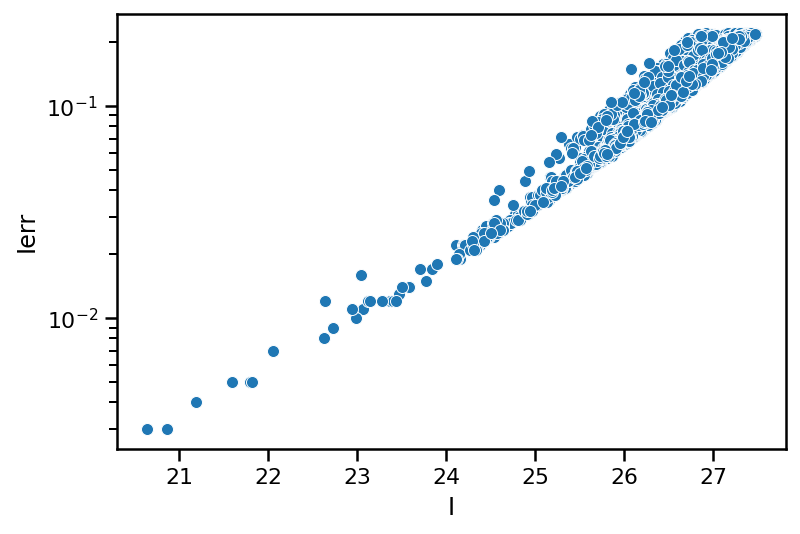

In [60]:
sns.scatterplot(data=data_cut, x='I', y='Ierr')
plt.yscale('log')

Let's try to make up an uncertainty relation here.  We imagine that the uncertainty is driven by counting uncertainty on the CCD, and that there is a constant-rate background.  The flux is proportional to 
$$
F \propto 10^{I/-2.5} = \exp\left(- \frac{I \log 10}{2.5} \right),
$$
and therefore 
$$
\frac{\sigma_F}{F} = \frac{\log 10}{2.5} \sigma_I
$$

Let's see what $\sigma_F$ looks like:

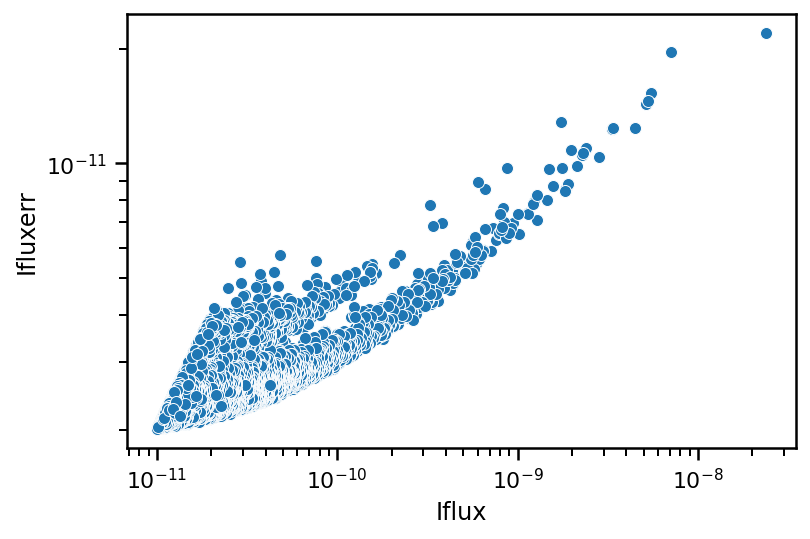

In [61]:
sns.scatterplot(data=data, x='Iflux', y='Ifluxerr')
plt.xscale('log')
plt.yscale('log')

If the flux uncertainty is driven by Poisson counting uncertainty, then it out to scale like $\sqrt{A + BF}$, or 
$$
\sigma_F^2 = A + B F
$$
where $A$ is associated with a (constant) background rate.

In [62]:
MI = np.column_stack((np.ones_like(data['Ifluxerr']), data['Iflux']))
bI, _, _, _ = np.linalg.lstsq(MI, data['Ifluxerr']**2, rcond=None)

MV = np.column_stack((np.ones_like(data['Vfluxerr']), data['Vflux']))
bV, _, _, _ = np.linalg.lstsq(MV, data['Vfluxerr']**2, rcond=None)

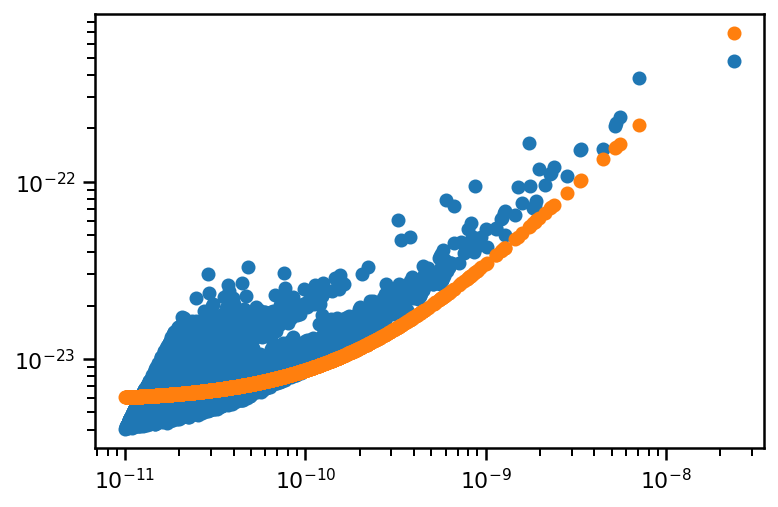

In [63]:
plt.scatter(data['Iflux'], data['Ifluxerr']**2)
plt.scatter(data['Iflux'], np.dot(MI, bI))
plt.xscale('log')
plt.yscale('log')

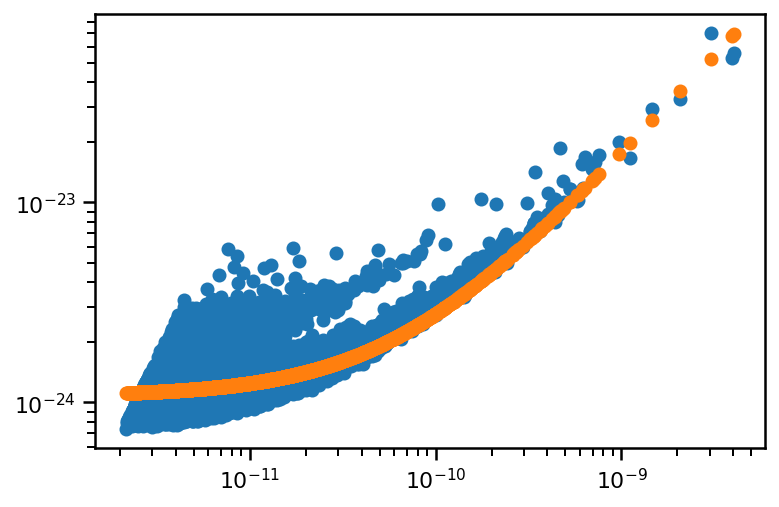

In [64]:
plt.scatter(data['Vflux'], data['Vfluxerr']**2)
plt.scatter(data['Vflux'], np.dot(MV, bV))
plt.xscale('log')
plt.yscale('log')

In [65]:
print('sigma^2_{{F_V}} = {:.2g} + {:.2g}*F_V'.format(*bV))
print('sigma^2_{{F_I}} = {:.2g} + {:.2g}*F_I'.format(*bI))

print('Lambda_V = {:.2g} + {:.2g}*F_V'.format(bV[0]/bV[1]**2, 1/bV[1]))
print('Lambda_I = {:.2g} + {:.2g}*F_I'.format(bI[0]/bI[1]**2, 1/bI[1]))

sigma^2_{F_V} = 1.1e-24 + 1.7e-14*F_V
sigma^2_{F_I} = 5.8e-24 + 2.9e-14*F_I
Lambda_V = 3.8e+03 + 5.9e+13*F_V
Lambda_I = 7.1e+03 + 3.5e+13*F_I


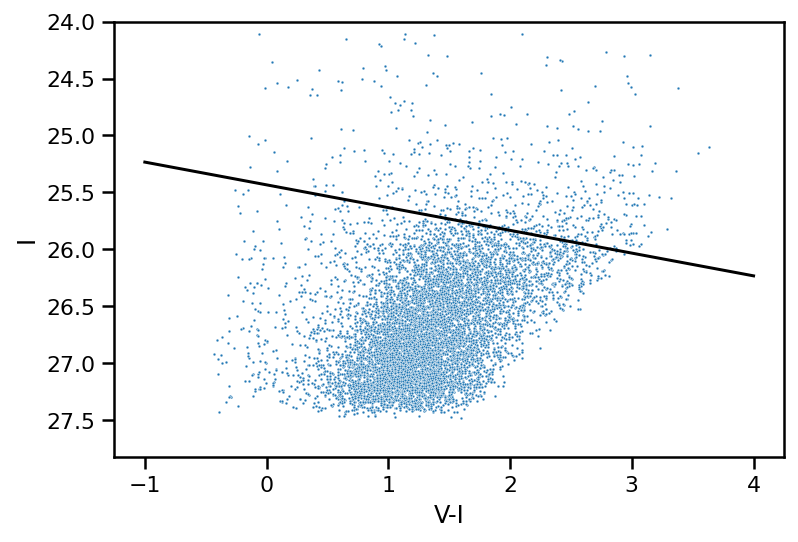

In [66]:
marker_s = 8

p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.', s=marker_s)
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

cs = np.linspace(-1, 4, 1024)
plt.plot(cs, trgb_mcquinn - c_mcquinn*(cs - c_center), 'k')

Or here is the result in "rectified" $I$ band.  The rectification seems to have made the "apparent" TRGB constant (i.e. flat in color), so that's good.

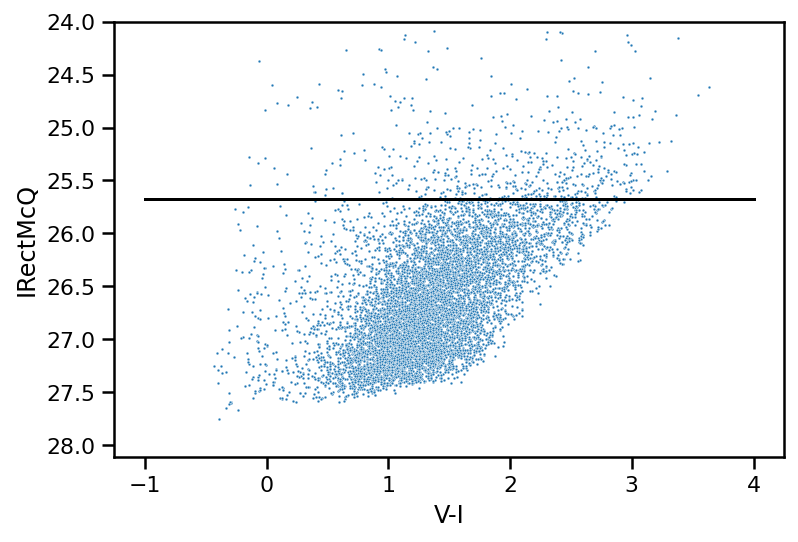

In [67]:
p = sns.scatterplot(data=data_cut, x='V-I', y='IRectMcQ', marker='.', s=marker_s)
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

cs = np.linspace(-1, 4, 1024)
plt.plot(cs, trgb_mcquinn*np.ones_like(cs), 'k')

In [68]:
Aobs = np.column_stack((data_cut['I'], data_cut['V']))
sigma_obs = np.column_stack((data_cut['Ierr'], data_cut['Verr']))
cov_obs = np.array([np.diag([Ie, Ve]) for (Ie, Ve) in zip(data_cut['Ierr'], data_cut['Verr'])])

c_mu = c_mcquinn
c_sigma = 0.01

e_center = 25.68
e_sigma = 0.1

In [71]:
num_chains=4
thinning=1
sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_chains=num_chains, num_warmup=1000*thinning, num_samples=1000*thinning, thinning=thinning)
mcmc.run(jax_prng_key(), Aobs, cov_obs, e_center_mu=e_center, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, c_center=c_center)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'f_bg'}>,
        <AxesSubplot:title={'center':'f_bg'}>]], dtype=object)

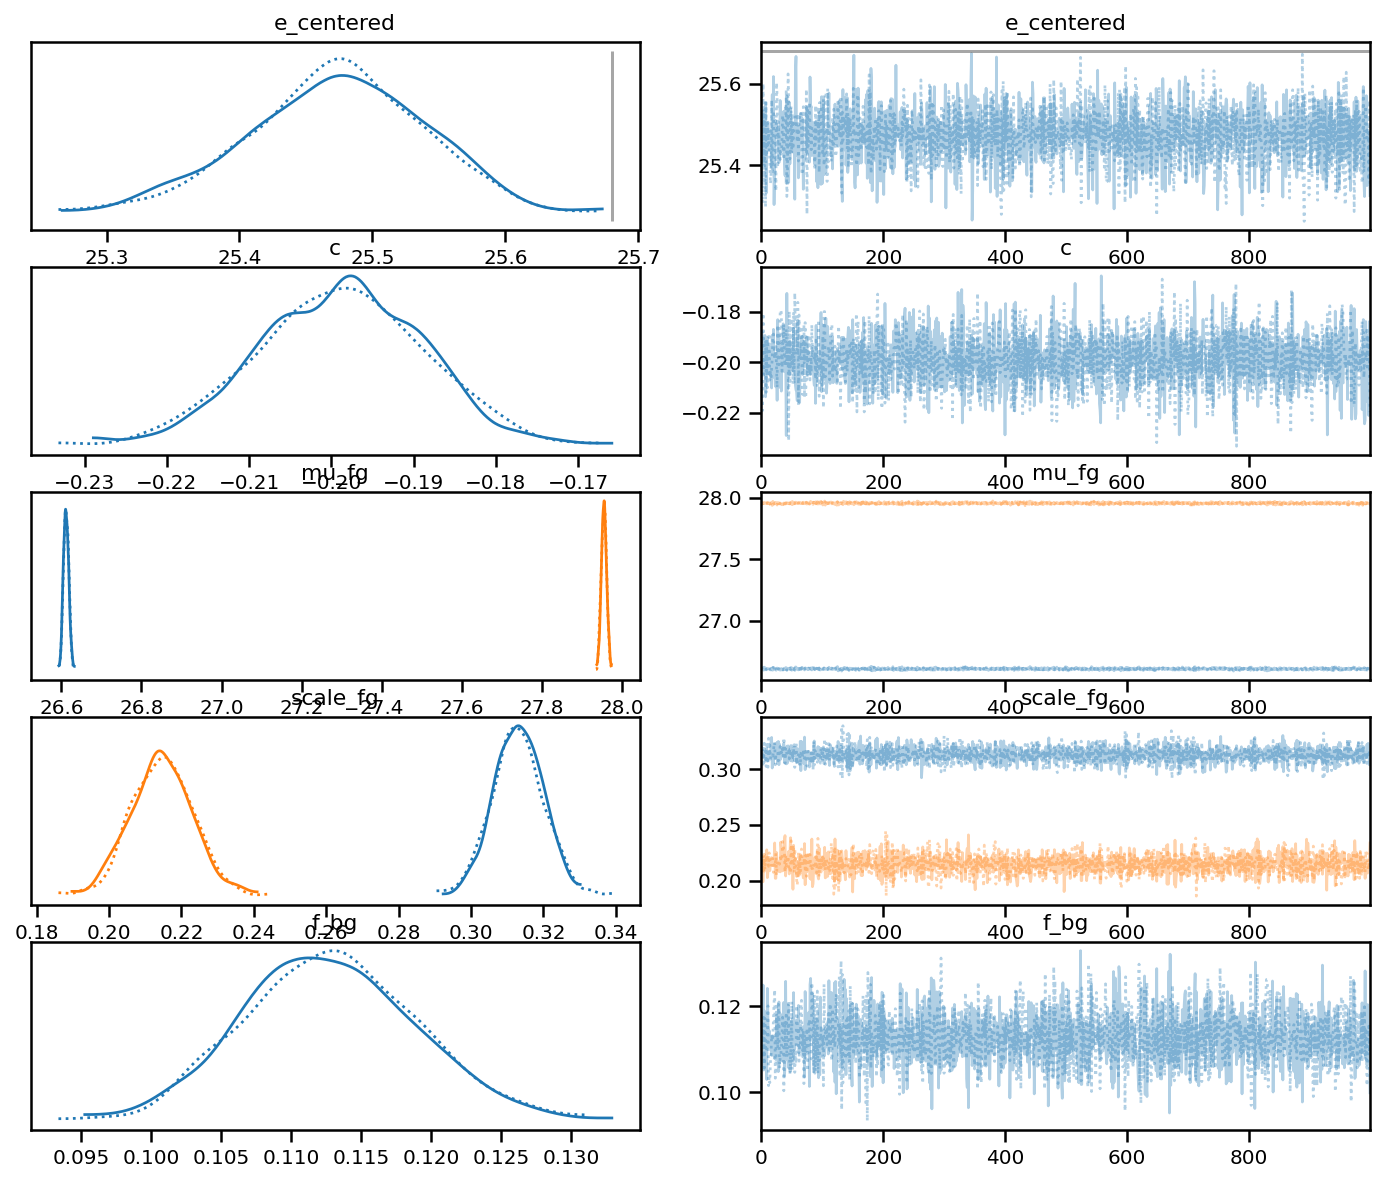

In [76]:
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'f_bg'],
              lines=[('e_centered', {}, e_center)])

In [74]:
trace.posterior.e_centered.mean(dim=['draw'])

<xarray.DataArray 'e_centered' (chain: 4)>
array([23.40166758, 25.47287925, 23.40319442, 25.47225758])
Coordinates:
  * chain    (chain) int64 0 1 2 3

In [75]:
trace.posterior = trace.posterior.sel(chain=[1,3])

In [77]:
az.summary(trace, var_names=['e_centered', 'c', 'f_bg', 'mu_fg', 'cov_fg'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e_centered,25.473,0.066,25.346,25.593,0.001,0.001,3699.0,1725.0,1.0
c[0],-0.199,0.010,-0.217,-0.179,0.000,0.000,3121.0,1501.0,1.0
f_bg,0.113,0.006,0.101,0.124,0.000,0.000,2922.0,1510.0,1.0
mu_fg[0],26.612,0.007,26.600,26.624,0.000,0.000,3169.0,1476.0,1.0
mu_fg[1],27.955,0.006,27.942,27.967,0.000,0.000,3284.0,1415.0,1.0
"cov_fg[0, 0]",0.098,0.004,0.090,0.106,0.000,0.000,3615.0,1458.0,1.0
"cov_fg[0, 1]",0.067,0.003,0.061,0.073,0.000,0.000,2876.0,1523.0,1.0
"cov_fg[1, 0]",0.067,0.003,0.061,0.073,0.000,0.000,2876.0,1523.0,1.0
"cov_fg[1, 1]",0.046,0.004,0.039,0.053,0.000,0.000,2827.0,1563.0,1.0


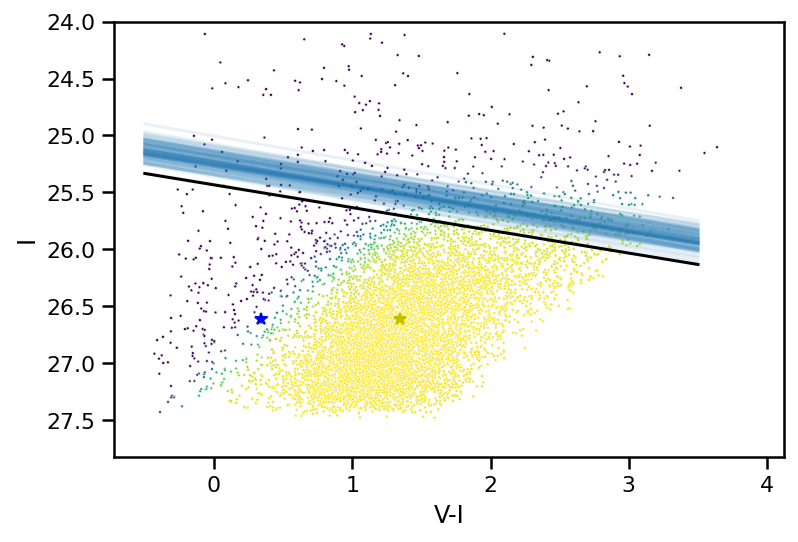

In [81]:
p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.', c=np.exp(trace.posterior.log_fg_prob).mean(axis=(0,1)), s=marker_s)
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

vis = np.linspace(-0.5, 3.5, 1024)
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    ec = trace.posterior.e_centered.sel(chain=c,draw=d).values
    c0 = trace.posterior.c.sel(chain=c,draw=d).values[0]
    plt.plot(vis, ec - c0*(vis - c_center), color=sns.color_palette()[0], alpha=0.1)
plt.plot(vis, trgb_mcquinn - c_mcquinn*(vis-c_center), color='k')

m = trace.posterior.mu_fg
plt.plot(m[:,:,1].mean()-m[:,:,0].mean(), m[:,:,0].mean(), '*y')
mb = trace.posterior.mu_bg
plt.plot(mb[:,:,1].mean()-m[:,:,0].mean(), m[:,:,0].mean(), '*b')

<AxesSubplot:title={'center':'e_centered'}>

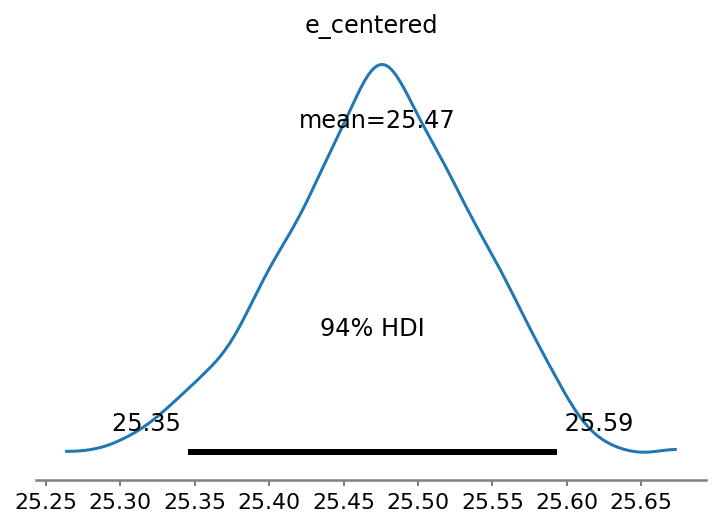

In [82]:
az.plot_posterior(trace, var_names='e_centered', round_to=4)

(27.5, 23.0)

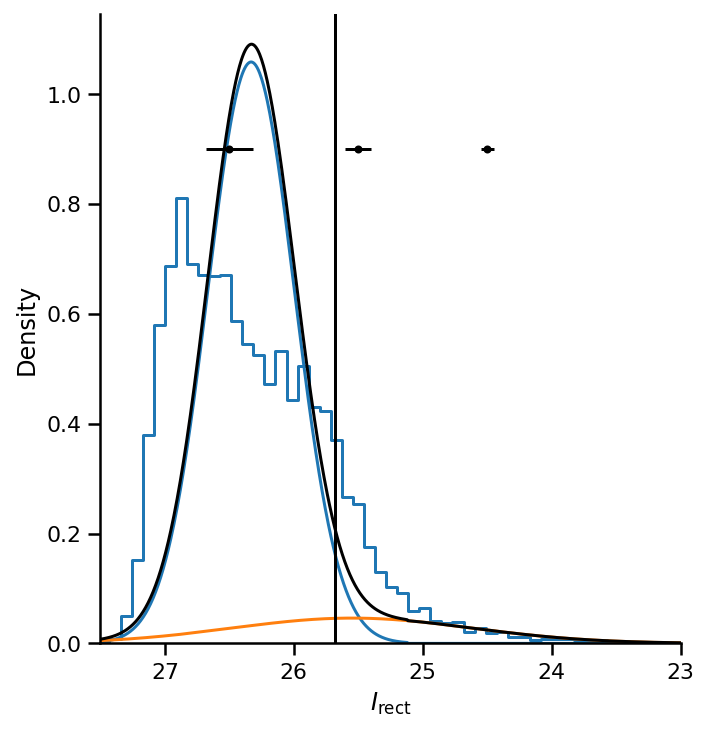

In [86]:
c = np.random.choice(trace.posterior.chain)
d = np.random.choice(trace.posterior.draw)

mu_f = trace.posterior.mu_fg.sel(chain=c,draw=d).values
cov_f = trace.posterior.cov_fg.sel(chain=c,draw=d).values
mu_bg = trace.posterior.mu_bg.sel(chain=c,draw=d).values
cov_bg = trace.posterior.cov_bg.sel(chain=c,draw=d).values
fb = trace.posterior.f_bg.sel(chain=c,draw=d).values
w = trace.posterior.w.sel(chain=c,draw=d).values
e = trace.posterior.e.sel(chain=c,draw=d).values
cc = trace.posterior.c.sel(chain=c,draw=d).values

mu_fe = np.dot(w, mu_f)
sigma_fe = np.sqrt(np.dot(w, np.dot(cov_f, w)))
mu_be = np.dot(w, mu_bg)
sigma_be = np.sqrt(np.dot(w, np.dot(cov_bg, w)))

Ae = np.dot(Aobs, w)

sns.displot(Ae, stat='density', element='step', fill=False)

Aes = np.linspace(23, 28, 1024)
p_bg = ss.norm(mu_be, sigma_be).pdf(Aes)
d_fg = ss.norm(mu_fe, sigma_fe)
p_fg = d_fg.pdf(Aes)*np.where(Aes > e, 1, 0)/(1-d_fg.cdf(e))
p = fb*p_bg + (1-fb)*p_fg
plt.plot(Aes, (1-fb)*p_fg)
plt.plot(Aes, fb*p_bg)
plt.plot(Aes, p, color='k')
#plt.axvline(e_center + c_center*cc, color='k')

errb = np.sqrt(np.dot(sigma_obs*sigma_obs, w*w))
for l in 27 - np.arange(3):
    mask = (Ae > l-1) & (Ae < l)
    plt.errorbar(l-0.5, 0.9, xerr=np.median(errb[mask]), fmt='.', color='k')

plt.axvline(trgb_mcquinn, color='k')

plt.xlabel(r'$I_\mathrm{rect}$')
plt.xlim(27.5, 23)